In [3]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type
import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import onnx
from onnx2pytorch import ConvertModel

In [2]:

from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple

import torch
import numpy as np
from collections import OrderedDict

ModuleNotFoundError: No module named 'auto_LiRPA'

In [4]:
def load_onnx_model(onnx_path, input_shape):
    onnx_model = onnx.load(onnx_path)
    torch_model = ConvertModel(onnx_model)
    
    x_concrete = torch.zeros(input_shape)
    model = BoundedModule(torch_model, x_concrete)
    return model

In [5]:
def load_vnnlib_spec(vnnlib_path, input_shape, n_out):
    n_in = np.prod(input_shape)
    res = read_vnnlib_simple(vnnlib_path, n_in, n_out)
    bnds, spec = res[0]
    
    bnds = np.array(bnds)
    lbs = bnds[:,0]
    ubs = bnds[:,1]
    
    data_min = torch.tensor(lbs, dtype=torch.float32).reshape(input_shape)
    data_max = torch.tensor(ubs, dtype=torch.float32).reshape(input_shape)
    center = 0.5*(data_min + data_max)

    ptb = PerturbationLpNorm(x_L=data_min, x_U=data_max)
    x = BoundedTensor(center, ptb)
    
    return x

In [6]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [7]:
transform = Compose([ToTensor(),  Normalize(0.5, 0.5)])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

In [8]:
nn = SequentialNN([28 * 28 * 1, 100, 30, 10])
nn.load_state_dict(torch.load("../../mnist_fc.pth", map_location=torch.device(device)), strict=False)


<All keys matched successfully>

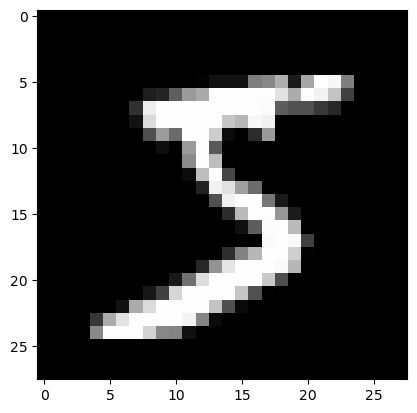

The label is 5
NN classifies image correctly as 5


In [9]:
# image to do the verification for
image_index = 0

# epsilon radius
eps = 0.026

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")

if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")

In [12]:
onnx_model_path = 'nn.onnx'

torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)

# Use the actual image tensor as input
torch.onnx.export(nn, torch_image, onnx_model_path)

In [ ]:
onnx_path = 'example_specs/mnist-net_256x4.onnx'
vnnlib_path = 'example_specs/prop_0_spiral_25.vnnlib'

In [ ]:
model = load_onnx_model(onnx_path, [1,1,1,784])
x = load_vnnlib_spec(vnnlib_path, [1,1,1,784], 10)

In [ ]:
model.compute_bounds(x=(x,), method='ibp')

In [ ]:
model.compute_bounds(x=(x,), method='crown')

In [ ]:
bounds = []
for layer_name in model.input_name:
    layer = model[layer_name]
    lower = layer.lower
    upper = layer.upper
    bounds.append([lower, upper])
    
print(bounds)